In [125]:
import pandas as pd
import matplotlib.pyplot  as plt
import os

### Подготовка данных для использования нейросетью

In [126]:
data_target = pd.read_csv('dataset time$ для finallu project/power.csv')
data_features = pd.read_csv('dataset time$ для finallu project/features.csv')



In [127]:
data = pd.merge(data_features, data_target, on='Timestamp')

validation = data[110000:len(data)]
data = data[0:110000]

In [128]:
validation

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,...,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315,Power(kW)
110000,2021-02-09 16:20:00,62.514999,65.121666,57.924999,60.000000,123.823792,62.261665,70.976944,45.000000,71.0,...,10.552004,9.890199,9.948302,9.170386,-41.809628,-39.602024,5.729250,1.0,5.737534,2759.405029
110001,2021-02-09 16:30:00,62.471668,64.943336,57.876667,59.966667,144.864227,62.270000,83.343010,45.000000,71.0,...,10.933712,10.273700,10.346166,9.540343,-8.078232,-9.838336,5.715740,1.0,5.740942,2759.915039
110002,2021-02-09 16:40:00,62.453335,65.000000,57.678333,60.000000,151.643158,62.119999,83.119080,45.000000,71.0,...,12.664343,12.008820,12.077250,11.286414,-10.210741,-8.598932,5.728962,1.0,5.753020,2762.451660
110003,2021-02-09 16:50:00,62.173332,64.973335,57.618332,59.900002,153.576019,61.998333,83.114090,45.000000,71.0,...,12.386012,11.734535,11.798157,11.019351,-25.083340,-22.922251,5.728218,1.0,5.745079,2762.068359
110004,2021-02-09 17:00:00,62.658333,65.000000,57.823334,60.000000,157.004944,62.348331,82.612968,45.000000,71.0,...,11.847301,11.202501,11.273156,10.486562,-17.392790,-16.231434,5.717533,1.0,5.737996,2760.573242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136725,2021-08-14 23:10:00,61.000000,63.000000,56.041668,58.000000,153.287247,60.000000,69.762711,49.000000,121.0,...,11.002503,10.447368,10.536141,9.802455,-32.086143,-31.424229,5.745283,1.0,5.745321,2757.728271
136726,2021-08-14 23:20:00,61.000000,62.393333,56.000000,58.000000,155.118393,60.000000,82.937195,49.000000,121.0,...,11.828915,11.272988,11.368523,10.622690,-23.889460,-22.231714,5.746785,1.0,5.750756,2758.323242
136727,2021-08-14 23:30:00,61.000000,62.000000,56.000000,58.000000,156.138977,60.000000,74.502060,49.000000,121.0,...,13.300327,12.743129,12.839147,12.089720,-4.717197,-5.553182,5.748488,1.0,5.761683,2759.243408
136728,2021-08-14 23:40:00,61.000000,62.000000,56.000000,58.000000,143.470795,60.000000,81.649567,49.000000,121.0,...,14.614794,14.055891,14.146004,13.405410,-7.466090,-10.808114,5.760780,1.0,5.772737,2761.261719


#### Функция по разделению набора данных на обучающую и тестовую выборки

In [129]:
def data_split(ts, param="77", train_percentage=0.67):
    timeseries = ts[ts.columns[int(param)]].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

#### Функция по преобразованию выборки в тензорный вид (необходимый для использования нейросетью)

In [130]:
import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

#### С помощью класса описывается базовая нейросеть LSTM
(возможно усложнение архиктуры в целях повышения качества)

In [131]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

#### Создается объект выборки, затем делится на тренировочную и тестовую с помощью функций, описанных выше

In [132]:
train, test, total = data_split(data)
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

#### Создается объект нейросети, оптимизатора, функции потерь и объекта загрузчика.
Данные объекты необходимы для осуществления обучения нейросети с помощью
библиотеки pytorch.

Указывается также количество эпох для обучения (итераций)

In [133]:
import numpy as np
import torch.optim as optim
import torch.utils.data as torch_data
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

EPOCHS = 200

Описывается функция для обучения

In [134]:
def train_model(model, X_train, X_test, y_train, y_test, n_epochs):
    y_pred_train = None
    y_pred_test = None

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        # Validation
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
            print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
        

        
    return y_pred_train, y_pred_test, model

#### Запуск обучения нейросети

In [135]:
y_pred_train, y_pred_test, model = train_model(model, X_train, X_test, y_train, y_test, EPOCHS)

Epoch 0: train RMSE 1381.9670, test RMSE 1451.1934
Epoch 1: train RMSE 1212.1819, test RMSE 1275.8467
Epoch 2: train RMSE 1051.4365, test RMSE 1108.9297
Epoch 3: train RMSE 892.6825, test RMSE 943.3081
Epoch 4: train RMSE 738.2121, test RMSE 781.2294
Epoch 5: train RMSE 664.2413, test RMSE 703.1627
Epoch 6: train RMSE 526.8127, test RMSE 557.5111
Epoch 7: train RMSE 446.3120, test RMSE 471.3975
Epoch 8: train RMSE 332.1589, test RMSE 349.4786
Epoch 9: train RMSE 297.6971, test RMSE 306.6516
Epoch 10: train RMSE 306.9243, test RMSE 318.2585
Epoch 11: train RMSE 285.0589, test RMSE 292.8389
Epoch 12: train RMSE 247.2889, test RMSE 250.1266
Epoch 13: train RMSE 249.3420, test RMSE 252.7775
Epoch 14: train RMSE 282.0230, test RMSE 290.9559
Epoch 15: train RMSE 315.1456, test RMSE 326.6540
Epoch 16: train RMSE 279.7639, test RMSE 288.5743
Epoch 17: train RMSE 288.8692, test RMSE 297.3995
Epoch 18: train RMSE 289.0339, test RMSE 295.8589
Epoch 19: train RMSE 279.6966, test RMSE 287.4586
Epoc

Сохранение обученной сети

### Пример подсчета метрик и построения графика 

In [136]:
import numpy as np
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                            r2_score)
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate(true, pred):
    true = pd.DataFrame(true.flatten().numpy())[0]
    pred = pd.DataFrame(pred.flatten().numpy())[0]
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred))

In [137]:
def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
    # shift train predictions for plotting
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1]
        # shift test predictions for plotting
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1]

    plt.rcParams["figure.figsize"] = [50, 12]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.show()

In [138]:
def validate_on_auto_measurement(model):
    valid_train, valid_test, valid_total = data_split(validation)    
    lookback = 1
    X_train, _ = create_dataset(valid_train, lookback=lookback)
    X_test, y_test = create_dataset(valid_test, lookback=lookback)

    y_pred = model(X_test)
    y_pred_test = y_pred
        
    print(f"Метрики для автоматического измерения:")
    try:
        validate(y_pred_test, y_test)
    except:
        validate(y_pred_test.detach(), y_test.detach())
    plot_train_n_pred(X_train, X_test, valid_total, model)

Вывод значений метрик, а также построение графика

Метрики для автоматического измерения:
MSE: 87567.35
RMSE: 295.9178121751038
MAE: 223.55989
MAPE: 58.17037224769592
R2: 0.8946568838776756


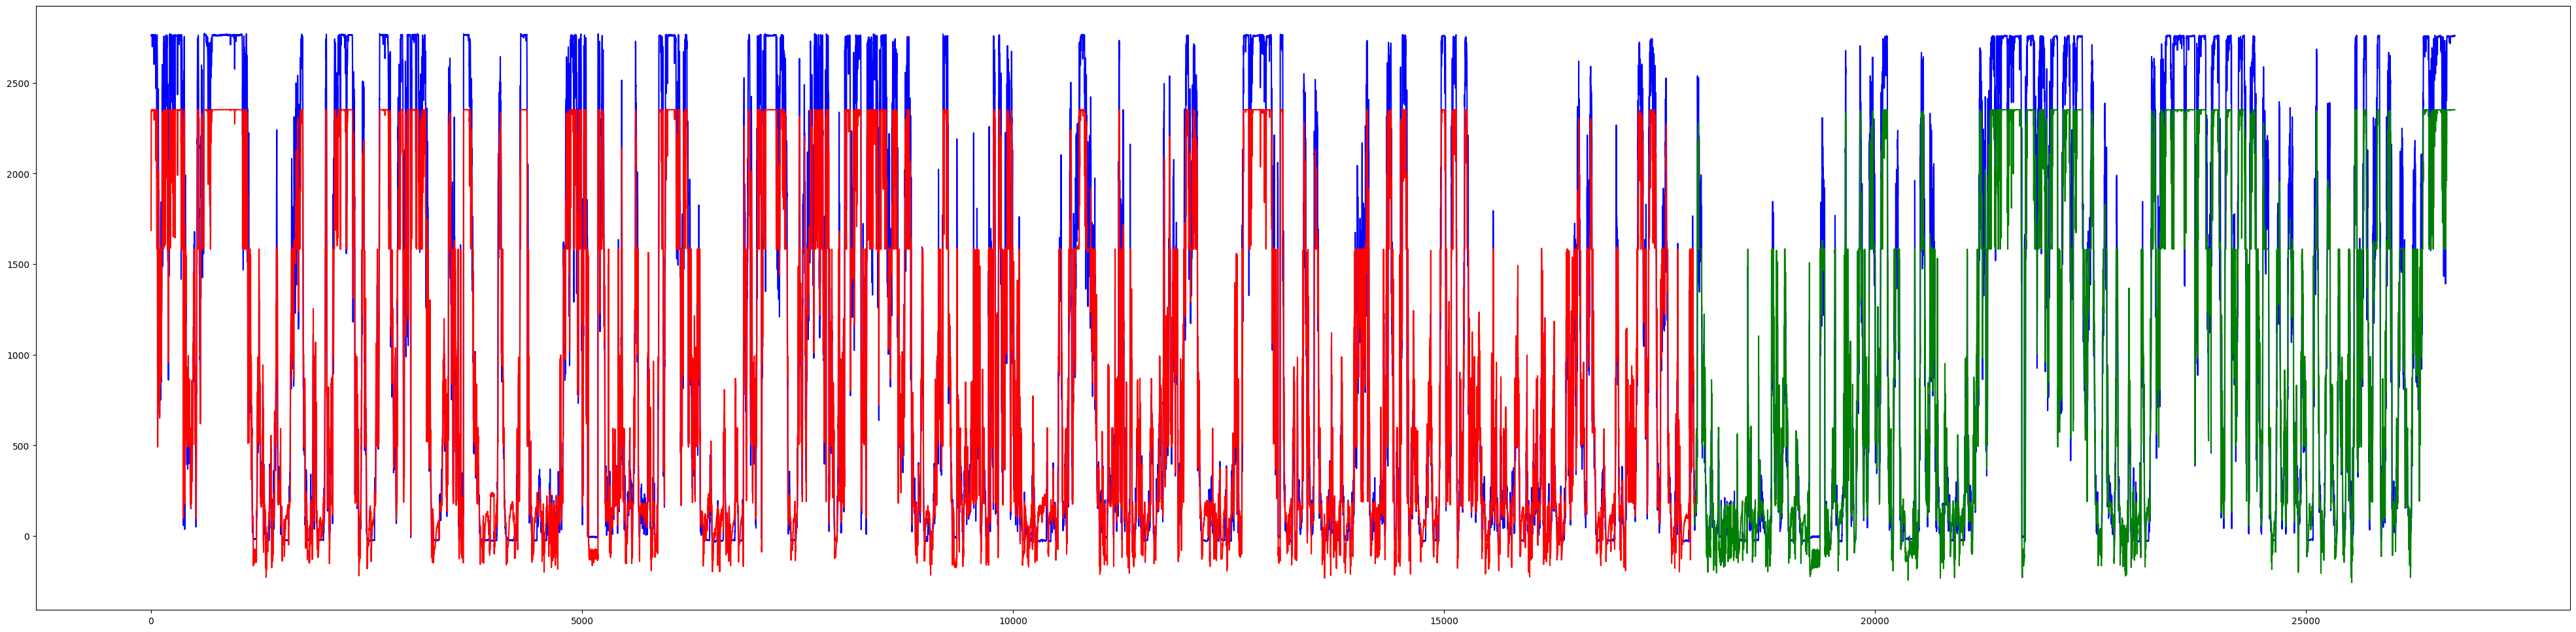

In [140]:
validate_on_auto_measurement(model)